Welcome to this tutorial for your coursework project. In this session, we will guide you through the process of deploying generative models as interactive web applications. You will be provided with a shared **Hugging Face (HF) account** to host and showcase your work via **Hugging Face Spaces**.

The goal of this coursework is not just to write code, but to demonstrate the capability of a generative model in a user-friendly format. You have three main categories to choose from for your demo.

### Project Options

**1. Refinement Demo: Customizing Existing Pipelines**
This option involves taking an existing Hugging Face Space or pipeline and refining it to create a specialized application.
*   **Scope:** You will modify an existing pipeline to make it more robust, interactive, or specific to a certain domain.
*   **Features:** This could involve patching the code of an existing model to improve stability, designing a specific UI that abstracts away complex prompting, **or equipping a single base model with multiple plugins (such as different LoRAs, ControlNets, or Adapters) to switch between specific capabilities.** For instance, instead of asking users for raw text prompts, you could build a specialized Icon Generator where users select specific options via dropdowns or buttons to control the output.
*   **Goal:** To transform a general-purpose model into a polished, domain-specific product with a high-quality user experience.

**2. Composition Demo: Chaining Multi-Modal Pipelines**
This option involves combining multiple existing Spaces or models to create a novel, complex workflow.
*   **Scope:** You will chain different models together, creating a pipeline where distinct components interact to solve a problem.
*   **Features:** This typically involves multi-modal interactions. For example, you might chain a Text-to-Image model with an Image-to-Image editing model, or use an LLM to refine and expand short user inputs into detailed prompts for a generation model.
*   **Goal:** To demonstrate the ability to orchestrate multi-modal interactions and ensure a seamless data flow where the output of one model serves as the input for the next (e.g., Generation followed by Editing).

### Recommended Workflow

To ensure a smooth development process, we recommend the following workflow:
1.  **Prototype:** Run and verify your pipeline logic in **Google Colab**.
2.  **Interface:** Wrap your code using **Gradio**, a Python library designed for creating ML demos quickly (See instructions from https://huggingface.co/docs/hub/spaces-sdks-gradio).
3.  **Deploy:** Migrate your Gradio app to **Hugging Face Spaces** using the shared accounts provided.

### Example: Accelerating SDXL with Hyper-SD

To demonstrate this workflow, we will look at a code example that falls under the **Refinement** category.

In this demo, we will take **Stable Diffusion XL (SDXL)**—a powerful but computationally heavy model—and optimize it for speed.
*   **The Problem:** Standard SDXL typically requires 30-50 inference steps to generate a high-quality image, which can take several seconds or even minutes depending on the hardware.
*   **The Solution:** We will load the **Hyper-SD LoRA**. This is a distillation technique that allows the model to generate high-quality images in as few as **2-8 steps**.
*   **The Implementation:** We will use the `diffusers` library to load the base model, fuse the acceleration weights, and adjust the scheduler to handle the reduced timestep count.

### Step 1: Install Dependencies

In [ ]:
!pip install -q diffusers transformers accelerate gradio peft

### Step 2: Load Model & Run Test

This cell loads SDXL, fuses the Hyper-SD weights, and generates a test image to verify everything is working.



Running on: cuda
Loading SDXL Base model...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading Hyper-SD LoRA (Hyper-SDXL-2steps-lora.safetensors)...


No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModelWithProjection found with the prefix='text_encoder_2'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModelWithProjection related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


Generating test image...


  0%|          | 0/2 [00:00<?, ?it/s]

Test Result:


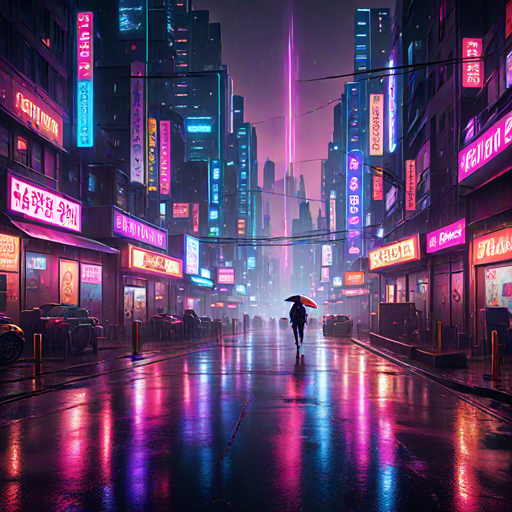

In [5]:
import torch
from diffusers import DiffusionPipeline, DDIMScheduler
from huggingface_hub import hf_hub_download
from IPython.display import display

# 1. Setup Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on: {device}")

# 2. Define Model IDs
base_model_id = "stabilityai/stable-diffusion-xl-base-1.0"
repo_name = "ByteDance/Hyper-SD"
# We use the 2-step LoRA for maximum acceleration
ckpt_name = "Hyper-SDXL-2steps-lora.safetensors"

# 3. Load Base Pipeline
print("Loading SDXL Base model...")
pipe = DiffusionPipeline.from_pretrained(
    base_model_id,
    torch_dtype=torch.float16,
    variant="fp16"
).to(device)

# 4. Load and Fuse Hyper-SD LoRA
print(f"Loading Hyper-SD LoRA ({ckpt_name})...")
pipe.load_lora_weights(hf_hub_download(repo_name, ckpt_name))
pipe.fuse_lora()

# 5. Configure Scheduler
# CRITICAL: Hyper-SD requires 'trailing' timestep spacing to work correctly
pipe.scheduler = DDIMScheduler.from_config(
    pipe.scheduler.config,
    timestep_spacing="trailing"
)

# 6. Run a Test Generation
print("Generating test image...")
prompt = "a cinematic photo of a cyberpunk street, neon lights, rain, 8k, highly detailed"
image = pipe(prompt=prompt, num_inference_steps=2, guidance_scale=0).images[0]

print("Test Result:")
display(image.resize((512, 512)))

### Step 3: Interactive Gradio Demo

Run this cell to launch the interactive UI directly inside the notebook.

In [6]:
import gradio as gr
import random

def generate_image(prompt, seed):
    # Set seed for reproducibility
    generator = torch.Generator(device).manual_seed(int(seed))

    # Run Inference
    # Note: guidance_scale=0 is recommended for Hyper-SD 2-step
    image = pipe(
        prompt=prompt,
        num_inference_steps=2,
        guidance_scale=0,
        generator=generator
    ).images[0]

    return image

# Build the Interface
with gr.Blocks() as demo:
    gr.Markdown("## ⚡ Hyper-SDXL: 2-Step Image Generation")
    gr.Markdown("Generating high-quality SDXL images in just 2 steps.")

    with gr.Row():
        with gr.Column():
            prompt_input = gr.Text(
                label="Prompt",
                value="a futuristic white robot standing in a garden, 8k, masterpiece"
            )
            seed_input = gr.Number(label="Seed", value=42)
            run_btn = gr.Button("Generate", variant="primary")

        with gr.Column():
            output_image = gr.Image(label="Result")

    # Connect inputs to function
    run_btn.click(
        fn=generate_image,
        inputs=[prompt_input, seed_input],
        outputs=output_image
    )

# Launch with debug=True to see errors in the notebook output
demo.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://820b93bfff9b5ca27f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/diffusers/pipelines/stable_diffusion_xl/pipeline_stable_diffusion_xl.py:748: FutureWarning: `upcast_vae` is deprecated and will be removed in version 1.0.0. `upcast_vae` is deprecated. Please use `pipe.vae.to(torch.float32)`. For more details, please refer to: https://github.com/huggingface/diffusers/pull/12619#issue-3606633695.
  deprecate(


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://820b93bfff9b5ca27f.gradio.live


### Step 4: Deployment

To deploy your Google Colab prototype to **Hugging Face Spaces**, you need to make two main changes:

1.  **Create a `requirements.txt` file:** This tells the server which libraries to install (replacing the `!pip install` commands).
2.  **Add ZeroGPU compatibility:** You need to import the `spaces` library and add the `@spaces.GPU` decorator to your generation function. This allows your app to access the shared GPU resources on Hugging Face.

Here are the files you need to create in your Space.

### 1. requirements.txt
Create a new file named `requirements.txt` and paste the following dependencies:

```text
diffusers
transformers
accelerate
gradio
huggingface_hub
spaces
torch
peft
```

### 2. app.py
Create a new file named `app.py`. This contains your logic.

**Key Changes from Colab:**
*   **`import spaces`**: Added at the top.
*   **`@spaces.GPU`**: Added right before the `generate_image` function. This is crucial; without it, the code will fail or run on CPU (which is too slow).
*   **Model Loading**: We load the model globally (outside the function) so it only loads once when the server starts, not every time a user clicks "Generate".

```python
import gradio as gr
import torch
import spaces
from diffusers import DiffusionPipeline, DDIMScheduler
from huggingface_hub import hf_hub_download

# 1. Setup Configuration
base_model_id = "stabilityai/stable-diffusion-xl-base-1.0"
repo_name = "ByteDance/Hyper-SD"
ckpt_name = "Hyper-SDXL-2steps-lora.safetensors"
device = "cuda" if torch.cuda.is_available() else "cpu"

# 2. Load Model (Global Scope)
# We load the model once here so it stays in memory.
print("Loading SDXL and Hyper-SD LoRA...")

pipe = DiffusionPipeline.from_pretrained(
    base_model_id,
    torch_dtype=torch.float16,
    variant="fp16"
).to(device)

# Load and fuse the LoRA weights
pipe.load_lora_weights(hf_hub_download(repo_name, ckpt_name))
pipe.fuse_lora()

# Configure the scheduler for Hyper-SD (Trailing spacing is required)
pipe.scheduler = DDIMScheduler.from_config(
    pipe.scheduler.config,
    timestep_spacing="trailing"
)

print("Model loaded successfully.")

# 3. Define the Generation Function
# The @spaces.GPU decorator handles GPU allocation for this specific function.
@spaces.GPU
def generate_image(prompt, seed):
    print(f"Generating: {prompt}")
  
    # Set seed for reproducibility
    generator = torch.Generator(device).manual_seed(int(seed))
  
    # Run Inference (2 steps, 0 guidance)
    image = pipe(
        prompt=prompt,
        num_inference_steps=2,
        guidance_scale=0,
        generator=generator
    ).images[0]
  
    return image

# 4. Build the Gradio Interface
css = """
.container { max-width: 800px; margin: auto; }
"""

with gr.Blocks(css=css) as demo:
    gr.Markdown("# ⚡ Hyper-SDXL: 2-Step Generation")
    gr.Markdown("This demo uses Hyper-SD LoRA to accelerate SDXL, generating high-quality images in just **2 inference steps**.")
  
    with gr.Row():
        with gr.Column():
            prompt_input = gr.Text(
                label="Prompt",
                value="a cinematic photo of a cyberpunk street, neon lights, rain, 8k, highly detailed",
                lines=3
            )
            seed_input = gr.Number(label="Seed", value=42)
            run_btn = gr.Button("Generate Image", variant="primary")
          
        with gr.Column():
            output_image = gr.Image(label="Result", type="pil")

    # Connect inputs to function
    run_btn.click(
        fn=generate_image,
        inputs=[prompt_input, seed_input],
        outputs=output_image
    )

# 5. Launch
if __name__ == "__main__":
    demo.launch()
```

#### Guidelines on Creating new Space on HuggingFace

1. Visit https://huggingface.co/ and login
2. Select `New` and `Space`:

<img src="https://drive.google.com/uc?id=1r5GkK2h7T0548PHHrIHoBqkF4EkRLM-y" width="25%">

3. Select `Owner` to be `mvp-lab`, `Space SDK` to be default `Gradio`, `Space hardware` to be `ZeroGPU`, name your space then create:

<img src="https://drive.google.com/uc?id=1l1aA0eFkTMDX1WCAUVwdZcgrXdm6ekI-" width="40%">

4. Go to `files` of the space, upload/create your `requirements.txt` and `app.py`. If necessary, you may need to upload/create other files related to the project.

<img src="https://drive.google.com/uc?id=1ktSY4kkSwvxtmw1goXetGQ6rIKOtRJib" width="40%">

5. When you have everything to construct your app uploaded, the space will start to build automatically. After building, your space will be publicly available and playable through link like: https://huggingface.co/spaces/mvp-lab/70113_test